# Sounds Like
Find a song that sounds like something you would love to listen to

In [ ]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import requests
import zipfile
import tarfile
import torch
import torch.nn.functional as F

from torch import nn, optim
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from utils.converter import h5_to_dict
from pathlib import Path
from random import randint

In [ ]:
# Create the data directory
Path.mkdir(Path("data"), exist_ok=True)

In [ ]:
OUTPUT_CSV_PATH = "data/songs.csv"
INPUT_FILE_PATH = "data/MillionSongSubset"

## Download resources

You will need to download all of these resources before you can continue. Altogether, you will need at most 4 GB of storage available. If you prefer not doing it yourself, the next cell after this will automatically download and extract everything. However, it will take noticeably longer to uncompress the data.

1. [Million Song Subset](http://labrosa.ee.columbia.edu/~dpwe/tmp/millionsongsubset.tar.gz")
2. [Sample Track](http://millionsongdataset.com/sites/default/files/AdditionalFiles/TRAXLZU12903D05F94.h5)
3. [Taste Profile](http://labrosa.ee.columbia.edu/~dpwe/tmp/train_triplets.txt.zip)
4. [Mismatched tracks](http://millionsongdataset.com/sites/default/files/tasteprofile/sid_mismatches.txt)

Running the cell below will **override any existing resources in the data folder**.

In [ ]:
RESOURCES = [
    "http://millionsongdataset.com/sites/default/files/tasteprofile/sid_mismatches.txt",
    "http://labrosa.ee.columbia.edu/~dpwe/tmp/train_triplets.txt.zip",
    "http://labrosa.ee.columbia.edu/~dpwe/tmp/millionsongsubset.tar.gz",
    "http://millionsongdataset.com/sites/default/files/AdditionalFiles/TRAXLZU12903D05F94.h5",
    "http://millionsongdataset.com/sites/default/files/thisismyjam/jam_to_msd.tsv",
    "https://archive.org/download/thisismyjam-datadump/thisismyjam-datadump.zip"
]

files_downloaded = 0

for resource in RESOURCES:
    # Download all resources
    local_filename = resource[resource.rindex("/") + 1:]

    try:
        with requests.get(resource, stream=True) as r:
            r.raise_for_status()

            with open(f"data/{local_filename}", "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        
        files_downloaded += 1
    except Exception as e:
        print(f"Failed to download resource - {resource}.\nError: {e}\nDO NOT PROCEED TO THE NEXT CELL.")
        break

print(f"{files_downloaded} of {len(RESOURCES)} resources(s) downloaded")

if files_downloaded == len(RESOURCES):
    # Extract compressed resources
    with tarfile.open("data/millionsongsubset.tar.gz", "r:gz") as tar:
        tar.extractall("data/")
    with zipfile.ZipFile("data/train_triplets.txt.zip", "r") as zip:
        zip.extractall("data/")
    with zipfile.ZipFile("data/thisismyjam-datadump.zip", "r") as zip:
        zip.extractall("data/")
    
    # Delete the zip files
    os.remove("data/millionsongsubset.tar.gz")
    os.remove("data/train_triplets.txt.zip")
    os.remove("data/thisismyjam-datadump.zip")
    
    print("Done. All data uncompressed successfully.")

## Import data
If you already have the song dataset ready as a pandas dataframe, then you can skip Cell 4 and start executing from Cell 5 to import your data. If you do not have a pandas dataframe containing your songs yet, you must run Cell 4 if you need to convert the HDF5 files in the MillionSong dataset into a pandas dataframe.

In [ ]:
# RUN !!ONLY!! THIS (AND NOT THE CELL BELOW) IF songs.csv DOES NOT EXIST in your data/ folder
# This will take approximately 10 minutes for 10,000 records.
rows = []

for root, _, files in os.walk(INPUT_FILE_PATH):
	for file in files:
		h5_path = os.path.join(root, file)
		try:
			song_data = h5_to_dict(h5_path)
			rows.append(song_data)
		except Exception as e :
			print(f"Error loading file {file}: {e}")

df = pd.DataFrame(rows)
df.to_csv(OUTPUT_CSV_PATH , index=False)

print(f"CSV created: {OUTPUT_CSV_PATH}")

In [ ]:
# RUN !!ONLY!! THIS (AND NOT THE CELL ABOVE) IF songs.csv ALREADY EXISTS IN YOUR data/ folder
df = pd.read_csv("data/songs.csv")
df.head(10)

## Transform Taste Profile Subset

In order to create vector embeddings for our tracks, we will have to first transform the taste profile subset such that it contains the top 5 tracks of each user.

In [ ]:
# Reshape Taste Profile subset
temp_df = pd.read_csv(
    "data/train_triplets.txt",
    delimiter="\t",
    names=["user_id", "song_id", "play_count"],
)
temp_df = temp_df.sort_values(by=["user_id", "play_count"], ascending=[True, False])

# Only use a subset of the data
temp_df = temp_df.head(math.floor(len(temp_df.index) * 0.25))
temp_df.head()

In [ ]:
# Only use a subset of the data
temp_df = temp_df.head(math.floor(len(temp_df.index) * 0.01))
temp_df.head()

# Assign an index to every unique song in the list
codes, unique = pd.factorize(temp_df["song_id"])
temp_df["song_id_coded"] = pd.to_numeric(codes)

# Get some useful stats
num_songs = len(unique)
num_users = len(temp_df["user_id"].value_counts().keys())

# Find top 5 songs
limit = 5

track_cols = [f"track_{i}_coded" for i in range(1, limit + 1)]
top_songs = temp_df.groupby("user_id").head(limit)
taste_profile_df = (
    top_songs.groupby("user_id")["song_id_coded"].apply(list).reset_index()
)
taste_profile_df.columns = ["user", f"top_{limit}_song_id_coded"]
taste_profile_df[[f"track_{i}_coded" for i in range(1, limit + 1)]] = pd.DataFrame(
    taste_profile_df[f"top_{limit}_song_id_coded"].to_list(), index=taste_profile_df.index
)

print(f"There are {num_songs} songs and {num_users} users in our selection.")

taste_profile_df.to_csv("data/taste_profile.csv", index=False)
taste_profile_df.head(10)

# Some basics in pandas and numpy

Reshaping matrices or arrays allows you to modify its dimensions.

If you need to produce a dataframe with only one feature then the best way to do it is `df[["feature"]]`. You can also use the same method to generate a dataframe with a subset of its original columns. Simply enter the columns you wish to select in the list like `df[["feature_1", "feature_2"]]`. The numpy equivalent of this is `np.reshape(df, (-1, 1))`. However, the disadvantage of using numpy is that the feature's names are not preserved.

In [ ]:
print(df.columns)

In [ ]:
plt.hist(df["analysis/songs/tempo"])

In [ ]:
plt.hist(df["analysis/songs/loudness"])

## Key
The key of the song where 0 represents C, 1 represents D and so on.

[Ref.](https://stackoverflow.com/questions/32202589/pyechonest-how-to-interpret-key-and-mode-attributes)

In [ ]:
plt.hist(df["analysis/songs/key"])

In [ ]:
plt.hist(df["analysis/songs/duration"])

## Mode
Indicates if the track is in the major key or minor key. In other words, a track is said to be in C Major if its key is 0 and its mode is 1.

[Ref.](https://stackoverflow.com/questions/32202589/pyechonest-how-to-interpret-key-and-mode-attributes)

In [ ]:
plt.hist(df["analysis/songs/mode"])

In [ ]:
plt.hist(df["analysis/songs/time_signature"])

## One Hot Encoding
As it currently stands, some categorical features exist in numerical formats which can cause the model to infer incorrect relationships. Taking key as an example, the model should not assume that there is some kind of increasing relationship from one key to the next but rather treat each key individually as separate features. Making multiple features for each key can be computationally expensive which is why we opt to create one-hot-encodings instead.

[Learn more](https://developers.google.com/machine-learning/crash-course/categorical-data/one-hot-encoding)

In [ ]:
# Create one-hot encoding vectors
encoder = OneHotEncoder(sparse_output=False)
encoder.set_output(transform="pandas")

df_encoded_keys = encoder.fit_transform(df[["analysis/songs/key"]])
df_encoded_mode = encoder.fit_transform(df[["analysis/songs/mode"]])

df = pd.concat([df, df_encoded_keys, df_encoded_mode], axis=1)

## Normalization

Some features need to be normalized to a common range to improve the model. Most features with an even distribution will be normalized using the Standard Scaler (Z-score distribution).

[Learn more](https://developers.google.com/machine-learning/crash-course/numerical-data/normalization)

In [ ]:
# Apply the StandardScaler to normalize datapoints in the tempo column using Z-score distribution
scaler = StandardScaler()

df["analysis/songs/tempo"] = scaler.fit_transform(df[["analysis/songs/tempo"]])
df["analysis/songs/loudness"] = scaler.fit_transform(df[["analysis/songs/loudness"]])
df["analysis/songs/duration"] = scaler.fit_transform(df[["analysis/songs/duration"]])

In [ ]:
plt.hist(df["analysis/songs/tempo"])

In [ ]:
plt.hist(df["analysis/songs/loudness"])

In [ ]:
plt.hist(df["analysis/songs/duration"])

## The Neural Network

In order to make good predictions of what a user might listen to, we ought to select the most appropriate model for the task. The best way to approach this problem would be to create embeddings for each song in the taste profile subset. To do this, we can select the top 5 songs of each user and then use the top 4 songs as features to predict the 5th song. This allows us to approach the problem as a supervised classification problem. By handling it this way, the model can learn latent features for each song as it tries to understand the relationship between the top 5 songs for each individual user. When we make the 5th song the objective of the learning, the model will try to create embeddings the first four songs and tries to understand their relationship. This should in theory correctly place similar songs closer together in the embedding space. The final output of the model would be a vector of probabilities representing the user's odds to interact with each item.

There are over 300,000 songs when you consider the whole dataset. This would be too large to represent using one-hot encodings since this would create very sparse input vectors of the order of 300,000 times the number of users. Instead, it would be more appropriate to give each song a label and allow the model to create lower dimensional embeddings to represent each song.

[Ref.](https://discuss.pytorch.org/t/what-kind-of-loss-is-better-to-use-in-multilabel-classification/32203/3)

### Creating targets

There are two ways of defining our model's objective. One method is to train the model to predict exactly the 5th song while the other alternative is to ensure that it predicts the correct odds of the user interacting with not only the 5th song but also the original 4. For this reason, we have two variants of the target - one being a one hot encoding of the 5th track and the other a multi hot encoding of all 5 tracks.

In [ ]:
# Creating target tensors for training the model
# Single-label targets where we try to predict the last track in the user's list of top n tracks
target_s = F.one_hot(
    torch.tensor(taste_profile_df[f"track_{len(track_cols)}_coded"].to_numpy()),
    num_classes=num_songs,
).type(torch.float32)

# Multi-label targets where we try to predict all of the user's top n tracks
tracks = torch.tensor(taste_profile_df[track_cols].to_numpy())

# Creates a matrix filled with zeroes of the size (num_users x num_songs),
# then fills it in with 1s based on the indices given in tracks.
# THIS WILL ONLY WORK CORRECTLY IF THE SONGS ARE ENCODED STRICTLY FROM 0 TO num_songs - 1
target_m = torch.zeros(num_users, num_songs).scatter_(1, tracks, 1.0)

model_input = torch.tensor(taste_profile_df[track_cols[:-1]].to_numpy())

In [ ]:
passes = 0
num_tests = 10000
for idx in range(num_tests):
    # Select a random user and a random song
    x = randint(0, num_users - 1)
    y = randint(0, num_songs - 1)
    z = randint(1, len(track_cols))

    # Expect 1 if the randomly selected user has the randomy selected song in their top 5
    expected_s = (
        1 if taste_profile_df.iloc[x][f"track_{len(track_cols)}_coded"] == y else 0
    )
    # At the same time, find out what song the randomly selected user actually likes
    song_id_s = taste_profile_df.iloc[x][f"track_{len(track_cols)}_coded"]
    song_id_m = taste_profile_df.iloc[x][f"track_{z}_coded"]

    cond_expected_s = (
        target_s[x][y].item() == expected_s and target_s[x][song_id_s].item() == 1
    )
    cond_expected_m = target_m[x][song_id_m].item() == 1

    if cond_expected_s:
        passes += 1

print(f"{passes} of {num_tests} tests passed.")
if passes < num_tests:
    print("Do not proceed with training.")

In [ ]:
device = (
    torch.accelerator.current_accelerator().type
    if torch.accelerator.is_available()
    else "cpu"
)
print(f"Using {device} device")

In [ ]:
input_len = 4   # The number of favourite songs considered as input for each user
embedding_dim = 3

In [529]:
class RecommendationModel(nn.Module):
    def __init__(self, num_songs, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_songs, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, 12)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(12, 12)
        self.fc3 = nn.Linear(12, num_songs)
    
    def forward(self, x):
        x = self.embedding(x)
        # x = x.mean(dim=1)
        x = x.max(dim=1)[0]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    
model = RecommendationModel(num_songs, embedding_dim)

In [530]:
loss_fn = nn.BCEWithLogitsLoss()
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

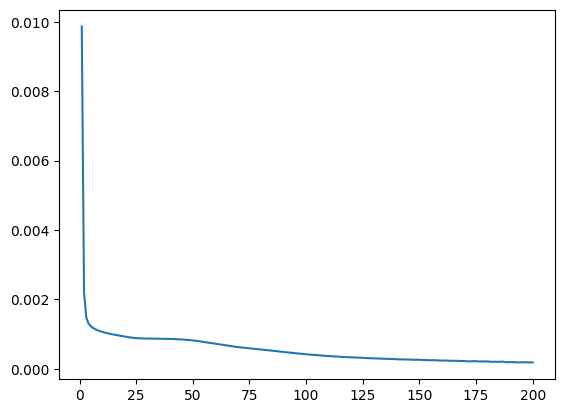

In [531]:
n_epochs = 200
batch_size = 10
loss_vals = []

for epoch in range(n_epochs):
    for i in range(0, len(model_input), batch_size):
        batch = model_input[i:i + batch_size]
        y_pred = model(batch)
        y_batch = target_m[i: i + batch_size]
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_vals.append(loss.item())

plt.plot([e + 1 for e in range(n_epochs)], loss_vals)

In [561]:
# Enter 4 songs as input. They must be encoded between 0 and num_songs - 1
profile = [56, 57, 59, 58]
logits = model(torch.tensor([profile]))
probabilities = F.softmax(logits, dim=1)

In [562]:
# Returns the top 5 songs that the user is likely to interact with.
torch.topk(probabilities, 10)

torch.return_types.topk(
values=tensor([[0.1811, 0.1381, 0.1165, 0.0392, 0.0388, 0.0382, 0.0369, 0.0327, 0.0181,
         0.0160]], grad_fn=<TopkBackward0>),
indices=tensor([[   56,    57,    58,  8964,  8969, 41632, 23219, 41633,  7986, 42481]]))